# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Enter The Frontier!

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [2]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from testing import Tester

In [3]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
openai = OpenAI()
claude = Anthropic()

In [6]:
%matplotlib inline

In [7]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

# Before we look at the Frontier

## There is one more model we could consider

In [18]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [19]:
# Read it back in

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [20]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $389.00 Error: $269.00 SLE: 1.37 Item: TLAPS 7422444293245 Compatible With 2016...
2: Guess: $80.00 Truth: $11.95 Error: $68.05 SLE: 3.36 Item: Witonics Capacitor Replacement Kit for L...
3: Guess: $35.00 Truth: $57.99 Error: $22.99 SLE: 0.24 Item: EPSIRMP E5T62172 Mass Air Flow Meter Sen...
4: Guess: $350.00 Truth: $32.99 Error: $317.01 SLE: 5.45 Item: 2 Pc 4 in 1 Double Box Ratcheting Wrench...
5: Guess: $75.00 Truth: $136.94 Error: $61.94 SLE: 0.36 Item: Can-Am 2013-2018 Outlander 650 Outlander...
6: Guess: $12.00 Truth: $116.10 Error: $104.10 SLE: 4.83 Item: OREI KVM 4K HDMI Over Ethernet Extender ...
7: Guess: $115.00 Truth: $249.97 Error: $134.97 SLE: 0.60 Item: MAXLINER Custom Fit Floor Mats and Cargo...
8: Guess: $100.00 Truth: $151.89 Error: $51.89 SLE: 0.17 Item: Alpinestars (474512-20-XS/S White X-Smal...
9: Guess: $300.00 Truth: $110.99 Error: $189.01 SLE: 0.98 Item: SCITOO automotive replacement engine rad...
10: Guess: $80.00 Truth: $218.78 Error:

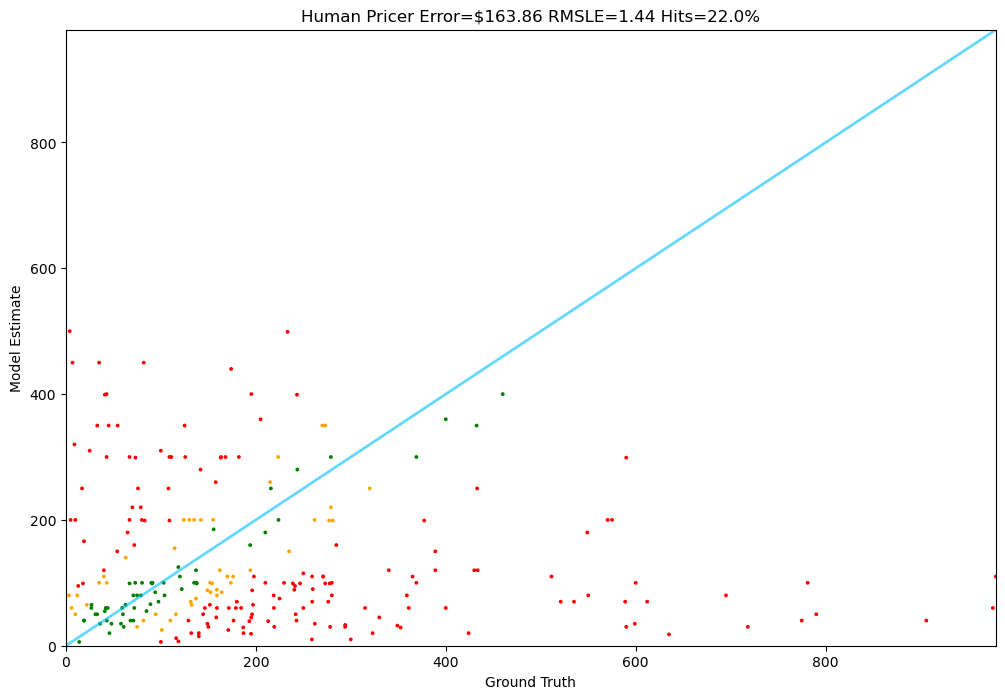

In [21]:
Tester.test(human_pricer, test)

## First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [8]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [9]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nTLAPS Compatible With Toyota Tacoma Non-Factory LED LED DRL Black Housing Full LED Sequential Quad Projector Headlights With Amber Reflector\nApplication Compatible With Toyota Tacoma Models With Non-Factory LED DRL ( Daytime Running Lights ) Headlights Only ( Attention Note Will Not Fit Models With Factory LED DRL ( Daytime Running Lights ) Headlights, Hyper Blinking May Occur If Used With Other Branded Aftermarket LED Lighting ) Full LED Sequential Projector Headlights ( Attention These LED Projector Headlights Will ONLY Replace Factory OEM Halogen Style Headlights, Not Compatible With Factory Upgraded Projectors Or LED Headlights, Hyper Blinking May Occur If Used With Other Branded Aftermarket LED Lighting. For More Information Please Contact Us ) Quad-LED Projector Design With Amber Sequential'},
 {'role': 'assistan

In [10]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [11]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [12]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [13]:
test[0].price

389.0

1: Guess: $349.99 Truth: $389.00 Error: $39.01 SLE: 0.01 Item: TLAPS 7422444293245 Compatible With 2016...
2: Guess: $30.99 Truth: $11.95 Error: $19.04 SLE: 0.82 Item: Witonics Capacitor Replacement Kit for L...
3: Guess: $47.99 Truth: $57.99 Error: $10.00 SLE: 0.03 Item: EPSIRMP E5T62172 Mass Air Flow Meter Sen...
4: Guess: $25.99 Truth: $32.99 Error: $7.00 SLE: 0.05 Item: 2 Pc 4 in 1 Double Box Ratcheting Wrench...
5: Guess: $100.00 Truth: $136.94 Error: $36.94 SLE: 0.10 Item: Can-Am 2013-2018 Outlander 650 Outlander...
6: Guess: $99.99 Truth: $116.10 Error: $16.11 SLE: 0.02 Item: OREI KVM 4K HDMI Over Ethernet Extender ...
7: Guess: $159.99 Truth: $249.97 Error: $89.98 SLE: 0.20 Item: MAXLINER Custom Fit Floor Mats and Cargo...
8: Guess: $99.95 Truth: $151.89 Error: $51.94 SLE: 0.17 Item: Alpinestars (474512-20-XS/S White X-Smal...
9: Guess: $100.99 Truth: $110.99 Error: $10.00 SLE: 0.01 Item: SCITOO automotive replacement engine rad...
10: Guess: $400.00 Truth: $218.78 Error: $181.

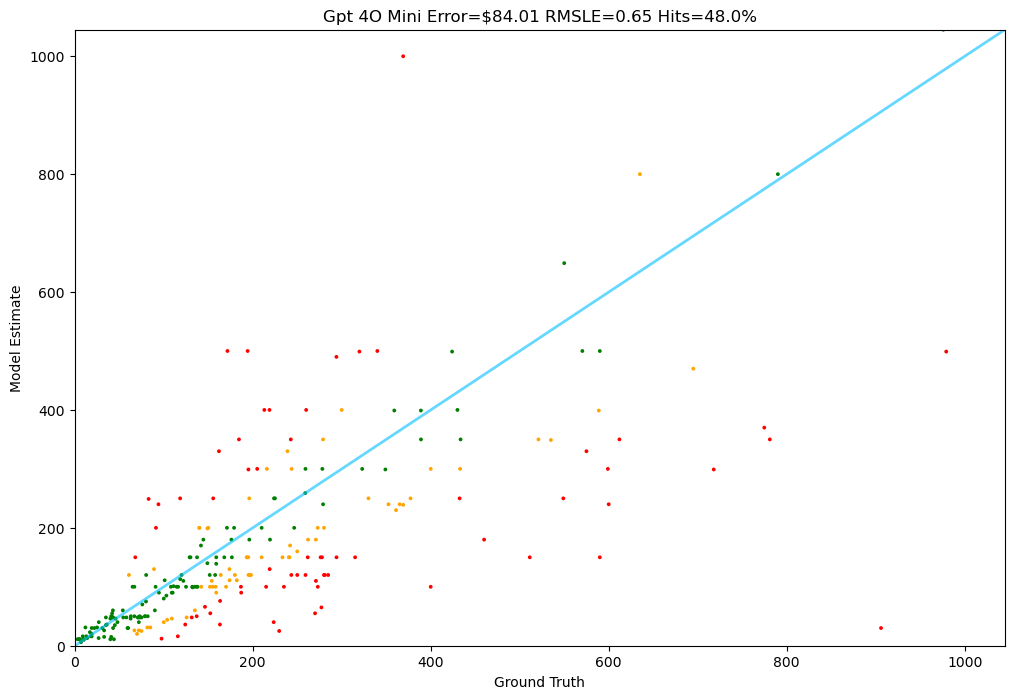

In [14]:
Tester.test(gpt_4o_mini, test)

In [15]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $800.00 Truth: $389.00 Error: $411.00 SLE: 0.52 Item: TLAPS 7422444293245 Compatible With 2016...
2: Guess: $15.00 Truth: $11.95 Error: $3.05 SLE: 0.04 Item: Witonics Capacitor Replacement Kit for L...
3: Guess: $30.00 Truth: $57.99 Error: $27.99 SLE: 0.41 Item: EPSIRMP E5T62172 Mass Air Flow Meter Sen...
4: Guess: $35.00 Truth: $32.99 Error: $2.01 SLE: 0.00 Item: 2 Pc 4 in 1 Double Box Ratcheting Wrench...
5: Guess: $150.00 Truth: $136.94 Error: $13.06 SLE: 0.01 Item: Can-Am 2013-2018 Outlander 650 Outlander...
6: Guess: $239.99 Truth: $116.10 Error: $123.89 SLE: 0.52 Item: OREI KVM 4K HDMI Over Ethernet Extender ...
7: Guess: $180.00 Truth: $249.97 Error: $69.97 SLE: 0.11 Item: MAXLINER Custom Fit Floor Mats and Cargo...
8: Guess: $179.95 Truth: $151.89 Error: $28.06 SLE: 0.03 Item: Alpinestars (474512-20-XS/S White X-Smal...
9: Guess: $100.00 Truth: $110.99 Error: $10.99 SLE: 0.01 Item: SCITOO automotive replacement engine rad...
10: Guess: $490.00 Truth: $218.78 Error: $2

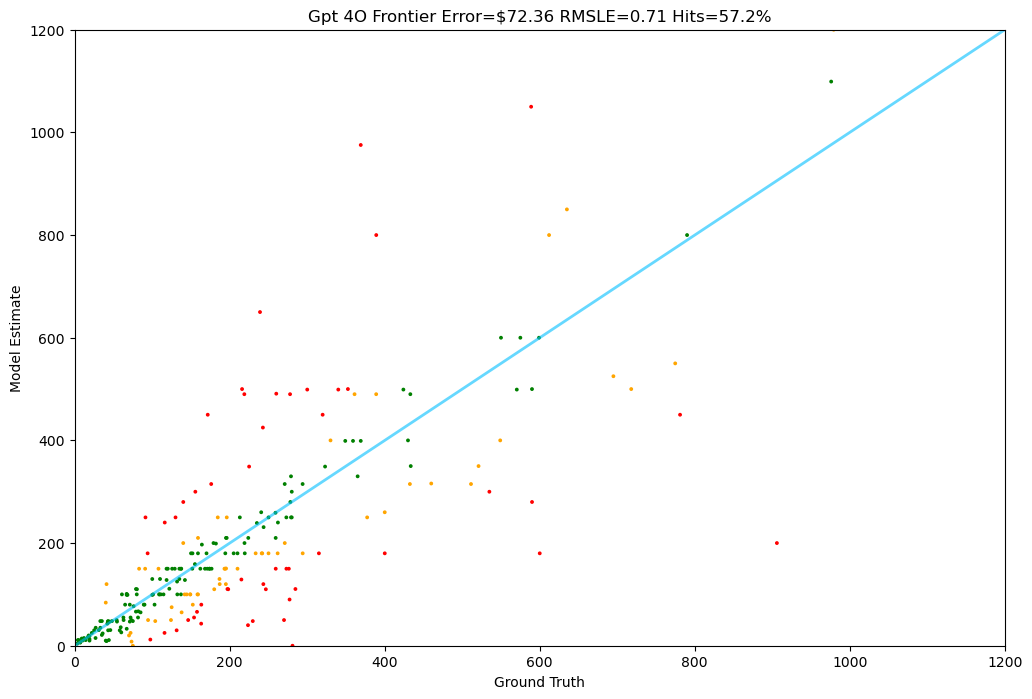

In [16]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier, test)

In [22]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

1: Guess: $499.99 Truth: $389.00 Error: $110.99 SLE: 0.06 Item: TLAPS 7422444293245 Compatible With 2016...
2: Guess: $14.99 Truth: $11.95 Error: $3.04 SLE: 0.04 Item: Witonics Capacitor Replacement Kit for L...
3: Guess: $49.99 Truth: $57.99 Error: $8.00 SLE: 0.02 Item: EPSIRMP E5T62172 Mass Air Flow Meter Sen...
4: Guess: $24.99 Truth: $32.99 Error: $8.00 SLE: 0.07 Item: 2 Pc 4 in 1 Double Box Ratcheting Wrench...
5: Guess: $199.99 Truth: $136.94 Error: $63.05 SLE: 0.14 Item: Can-Am 2013-2018 Outlander 650 Outlander...
6: Guess: $275.00 Truth: $116.10 Error: $158.90 SLE: 0.74 Item: OREI KVM 4K HDMI Over Ethernet Extender ...
7: Guess: $154.99 Truth: $249.97 Error: $94.98 SLE: 0.23 Item: MAXLINER Custom Fit Floor Mats and Cargo...
8: Guess: $99.95 Truth: $151.89 Error: $51.94 SLE: 0.17 Item: Alpinestars (474512-20-XS/S White X-Smal...
9: Guess: $89.99 Truth: $110.99 Error: $21.00 SLE: 0.04 Item: SCITOO automotive replacement engine rad...
10: Guess: $600.00 Truth: $218.78 Error: $381.

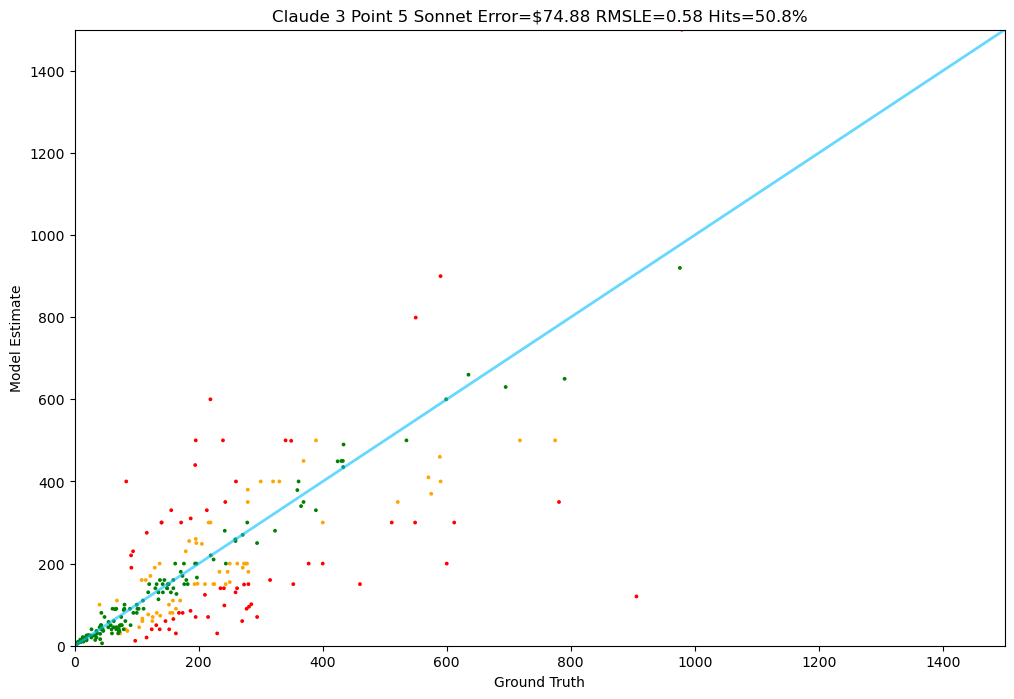

In [23]:
# The function for Claude 3.5 Sonnet
# It also cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(claude_3_point_5_sonnet, test)